# Fashion MINST Classification with 2D CNN
The notebook build CNN 2D model to classify the images of Fashion MNIST into 10 classes

## *Question: How does the 2D CNN model perform on classifying the images of fashion ? Which category does this model make more mistakes?*


### **Result:**

classification accuracy on test set is: 0.9024285674095154

label 6 — Shirt is easier to be classified as label 0 — T-shirt/top. 

CNN model performs relatively not well on classifying shirt.




### Import the libraries

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import sys
sys.modules['keras'] = keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras.datasets import mnist

### fix the seeds of random number generators, so the result will be reproducible

In [0]:
import random
random.seed(0)
np.random.seed(0)

### Define the 2D CNN network

In [0]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=120, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'))
model.add(Flatten())
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=10,  activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 120)         17400     
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 84)                1

## Load data

In [0]:
fasion_mnist=fetch_openml(name="Fashion-MNIST")
data=fasion_mnist.data
images=data.reshape(-1,28,28)
target=fasion_mnist.target.astype('int64')
x_train, x_test, y_train, y_test = train_test_split(images, target, test_size=0.2, random_state=0)
#normalization
x_train/=255 
x_test/=255

In [0]:
# look at the dimensions of data
x_train.shape

(56000, 28, 28)

In [0]:
x_train.max()

1.0

### Resize the images from 28x28 to 32x32

In [0]:
from skimage.transform import resize
x_train_resized=np.zeros((x_train.shape[0],32,32), dtype=np.float32)
for n in range(0, x_train.shape[0]):
    x = x_train[n,:,:]
    x = resize(x, [32, 32], mode='edge')
    x_train_resized[n,:,:]=x
x_test_resized=np.zeros((x_test.shape[0],32,32), dtype=np.float32)
for n in range(0, x_test.shape[0]):
    x = x_test[n,:,:]
    x = resize(x, [32, 32], mode='edge')
    x_test_resized[n,:,:]=x
x_train=x_train_resized
x_test=x_test_resized

### Reshape every data point
The size of the input tensor is (N, H, W, C),  C=1, H=W=32

In [0]:
x_train=x_train.reshape(-1,32,32,1)
x_test=x_test.reshape(-1,32,32,1)

### create a validation set

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)
print('train:', x_train.shape, y_train.shape)
print('validation:', x_val.shape, y_val.shape)
print('test:', x_test.shape, y_test.shape)

train: (50400, 32, 32, 1) (50400,)
validation: (5600, 32, 32, 1) (5600,)
test: (14000, 32, 32, 1) (14000,)


### show the images

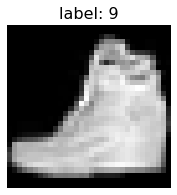

<Figure size 432x288 with 0 Axes>

In [0]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, x_train.shape[0], 5000):
    I = x_train[n].reshape(32,32)
    ax.imshow(I, cmap='gray')
    ax.set_title('label: ' + str(int(y_train[n])), fontsize=16)
    ax.axis('off')
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.1) 

In [0]:
# define a function to show the loss and accuray rate in the futher model training steps
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list,
                loss_test_list, acc_test_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].plot(loss_test_list, '-r', label='testing loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].plot(acc_test_list, '-r', label='testing accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

### train the neural network model over many epochs

In [0]:
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
loss_test_list=[]
acc_test_list=[]
epoch_save=-1

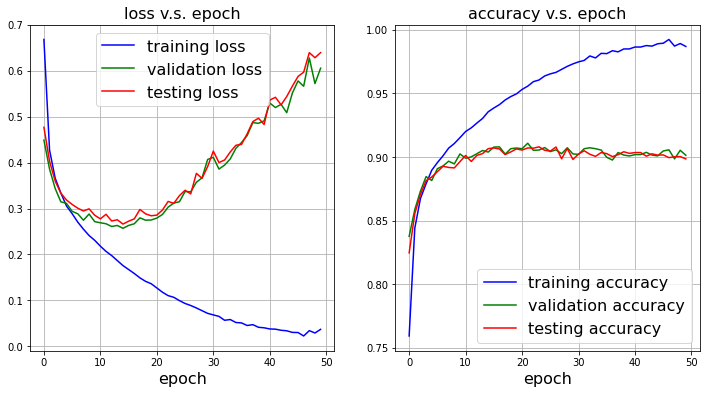

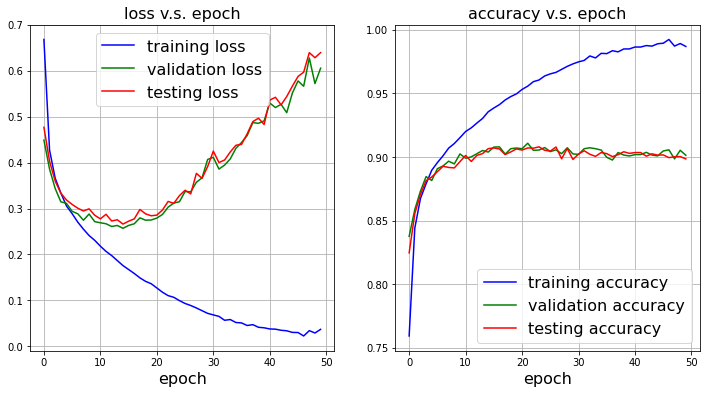

In [0]:
for epoch in range(epoch_save+1, 50):
    #-------- training and validation--------------------------------
    print('epoch', epoch)
    #set epochs=1
    history=model.fit(x_train, y_train, batch_size=128, epochs=1, validation_data=(x_val, y_val))    
    loss_train=history.history['loss'][0]
    acc_train=history.history['accuracy'][0]        
    loss_val=history.history['val_loss'][0]
    acc_val=history.history['val_accuracy'][0]     
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)    
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)
    #-------- testing --------------------------------
    score = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
    loss_test=score[0]
    acc_test=score[1]
    loss_test_list.append(loss_test)
    acc_test_list.append(acc_test)
    print('epoch', epoch, 'testing loss:', loss_test, 'acc:', acc_test)    
    #--------save model-------------------------
    model.save('LeNet5_Keras_epoch'+str(epoch)+'.h5')    
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list,
                          loss_test_list, acc_test_list)
    display.display(fig)

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f179c517f28>,
       dtype=object))

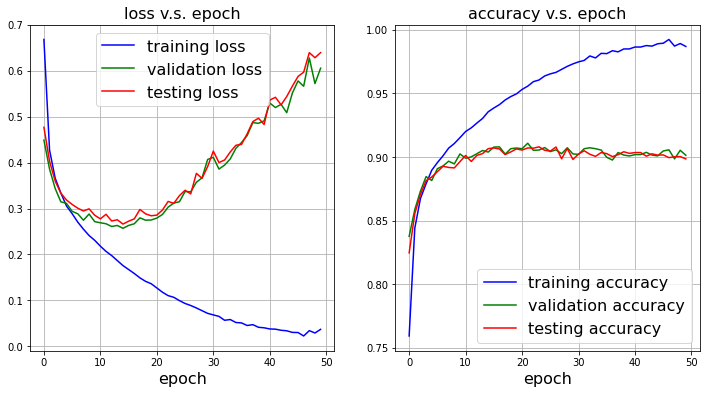

In [0]:
plot_result(loss_train_list, acc_train_list, 
            loss_val_list, acc_val_list,
            loss_test_list, acc_test_list)

### load the best model

In [0]:
best_id= np.array(acc_val_list).argmax()
best_id

21

In [0]:
from keras.models import load_model
model = load_model('LeNet5_Keras_epoch'+str(best_id)+'.h5')

### Evaluate the best model

#### Answer: Convolutional Neural Network with an accuracy rate around 0.9072142839431763

In [0]:
score = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2968486249446869
Test accuracy: 0.9072142839431763


In [0]:
y_test_pred=model.predict(x_test, batch_size=64)

In [0]:
y_test_pred[0]

array([9.6907081e-14, 9.4301509e-13, 3.5415648e-13, 7.5932417e-16,
       5.7469073e-12, 2.5332301e-09, 1.0791195e-13, 7.4834145e-07,
       2.8225683e-10, 9.9999928e-01], dtype=float32)

In [0]:
rounded_predictions = np.argmax(y_test_pred, axis=1)
print(rounded_predictions[0:10])

[9 5 6 6 2 6 4 7 6 6]


In [0]:
y_test[0]

9

### Create the confusion matrix

#### Answer: 

Actual label 6: label 6 — Shirt is easier to be classified as label 0 — T-shirt/top. 

CNN model performs relatively not well on classifying shirt.

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, rounded_predictions)
cm

array([[1215,    3,   24,   38,    0,    3,  101,    0,    7,    0],
       [   6, 1398,    0,   13,    3,    0,    1,    0,    3,    0],
       [  16,    2, 1212,   16,   63,    0,   56,    0,    1,    0],
       [  35,   10,   11, 1339,   32,    0,   27,    0,    1,    0],
       [   4,    3,   99,   54, 1138,    0,   89,    0,    1,    0],
       [   0,    0,    0,    0,    0, 1374,    1,   16,    1,    5],
       [ 172,    2,  112,   47,   67,    0, 1066,    0,    7,    0],
       [   0,    0,    0,    0,    0,   21,    0, 1305,    1,   27],
       [   6,    2,    7,    1,    4,    3,   15,    2, 1301,    0],
       [   1,    0,    0,    0,    0,    4,    0,   51,    2, 1353]])

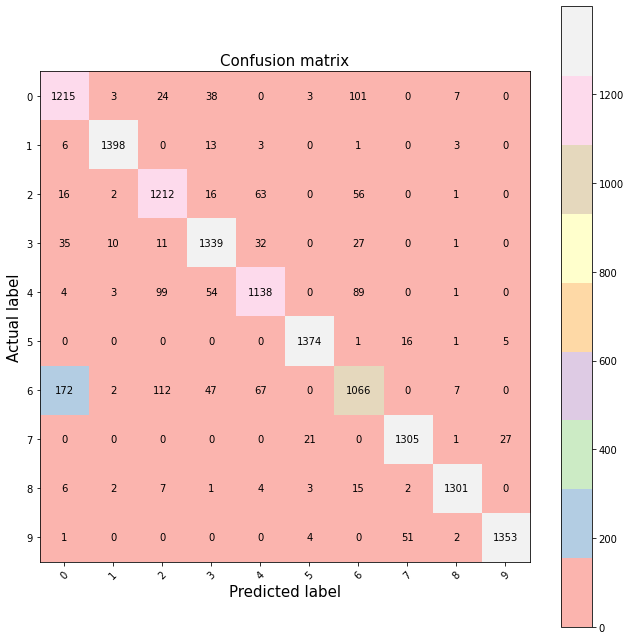

In [0]:
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], rotation=45, size = 10)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):    
  for y in range(height):
    plt.annotate(str(cm[x][y]), xy=(y, x), 
    horizontalalignment='center',
    verticalalignment='center')